In [1]:
# 1. Scarica il dataset da Google Drive
#import gdown

#url = "https://drive.google.com/drive/folders/10QLYLC6jmjRiKngnwg9J2bgs4E4AjVmC?usp=drive_link"
#output_dir = "./content/UWF-ZeekDataFall22"

#gdown.download_folder(url, output=output_dir, quiet=False)


In [2]:
# 2. Installa librerie necessarie
!pip install pyspark pyarrow scikit-learn shap lime matplotlib seaborn pandas numpy imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# 3. Configura Spark per leggere Parquet
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("UWFZeekXAI") \
    .config("spark.sql.parquet.enableVectorizedReader", "false") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/23 15:17:49 WARN Utils: Your hostname, sdm, resolves to a loopback address: 127.0.1.1; using 172.16.228.232 instead (on interface ens3)
25/06/23 15:17:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/23 15:17:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# 📁 4. Carica i file Parquet tranne quelli delle metriche
import glob

parquet_files = glob.glob("./content/UWF-ZeekDataFall22/parquet/2021*/*.snappy.parquet")
parquet_files += glob.glob("./content/UWF-ZeekDataFall22/parquet/2022*/*.snappy.parquet")
parquet_files = [f for f in parquet_files if "_parquet_" not in f]

# 📊 Carica il dataset in un DataFrame Spark
df_spark = spark.read.parquet(*parquet_files)
df_spark.createOrReplaceTempView("zeek_data")

print(df_spark.groupBy("label_binary").count().toPandas())

# 🚨 Filtra solo le tattiche MITRE ATT&CK di interesse
filtered_df = spark.sql("""
SELECT
  orig_pkts, resp_pkts, orig_bytes, resp_bytes, duration,
  proto, service, conn_state, history,
  label_binary, label_tactic, label_technique
FROM zeek_data
""")
# 📥 Scarica in Pandas per analisi locale
df_pandas = filtered_df.toPandas()
print("Shape:", df_pandas.shape)
df_pandas.head()

print(df_pandas['label_binary'].value_counts())

  label_binary   count
0         True  346933
1        False  350339
2    Duplicate    3068


Shape: (700340, 12)
label_binary
False        350339
True         346933
Duplicate      3068
Name: count, dtype: int64


In [5]:
# 🧮 5. Calcolo feature derivate utili
def safe_div(x, y):
    return x / y.replace(0, 1).astype(float)

df_pandas['pktAtsec'] = safe_div(df_pandas['orig_pkts'], df_pandas['duration'])
df_pandas['BitRate'] = safe_div((df_pandas['orig_bytes'] + df_pandas['resp_bytes']) * 8, df_pandas['duration'])
df_pandas['interTime'] = safe_div(df_pandas['duration'], df_pandas['orig_pkts'])
df_pandas['avgLenPkt'] = safe_div(df_pandas['orig_bytes'], df_pandas['orig_pkts'])

# 📈 Aggiungi feature aggregate
df_pandas['numPKT'] = df_pandas['orig_pkts'] + df_pandas['resp_pkts']
df_pandas['numBytes'] = df_pandas['orig_bytes'] + df_pandas['resp_bytes']

In [6]:
# 🧹 6. Preprocessing avanzato con One-Hot Encoding e Standardizzazione
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

continuous_features = ['orig_pkts', 'resp_pkts', 'orig_bytes', 'resp_bytes', 'duration', 'pktAtsec', 'BitRate', 'interTime', 'avgLenPkt']
categorical_features = ['proto', 'service', 'conn_state']

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),          # Imputation per numeriche
        ('scaler', StandardScaler())
    ]), continuous_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')), # Imputation per categoriche
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

In [7]:
# 🎯 7. Encoding etichette
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Y binario (gestione stringhe e numeri)
y_binary = df_pandas['label_binary'].replace({"True": 1, "False": 0, "Duplicate": 1}).astype(int)
# Y multiclasse
tactic_encoder = LabelEncoder()
y_tactic = tactic_encoder.fit_transform(df_pandas['label_tactic'].astype(str))

# 📊 8. Suddivisione train/test UNA SOLA VOLTA per tutto!
X_train, X_test, y_binary_train, y_binary_test, y_tactic_train, y_tactic_test = train_test_split(
    df_pandas[continuous_features + categorical_features], y_binary, y_tactic, test_size=0.2, stratify=y_binary, random_state=42
)

print("Train set:", np.bincount(y_binary_train))
print("Test set:", np.bincount(y_binary_test))
print(np.unique(y_binary_train))

# 🧠 9. Applica il preprocessor ai dati train/test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 🏷️ 10. Ricava i nomi delle feature dopo OHE (usato in XAI)
processed_cat_features = preprocessor.named_transformers_['cat']['ohe'].get_feature_names_out(categorical_features)
all_feature_names = continuous_features + list(processed_cat_features)


/tmp/ipykernel_640177/4024819625.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_binary = df_pandas['label_binary'].replace({"True": 1, "False": 0, "Duplicate": 1}).astype(int)


Train set: [280271 280001]
Test set: [70068 70000]
[0 1]


In [8]:
# 🌲 11. Addestramento modelli interpretabili
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Naive Bayes": GaussianNB()
}

# 🧪 12. Addestra e stampa stato
for name, model in models.items():
    try:
        model.fit(X_train_processed, y_binary_train)
        print(f"[✅] {name} addestrato per classificazione binaria")
    except Exception as e:
        print(f"[❌] Errore nel training {name}: {e}")

[✅] Random Forest addestrato per classificazione binaria
[✅] Decision Tree addestrato per classificazione binaria
[✅] Logistic Regression addestrato per classificazione binaria
[✅] Naive Bayes addestrato per classificazione binaria


In [9]:
# 📊 13. Valutazione dei modelli binari
from sklearn.metrics import classification_report

results_binary = {}
for name, model in models.items():
    try:
        y_pred = model.predict(X_test_processed)
        results_binary[name] = classification_report(y_binary_test, y_pred, output_dict=True)
        print(f"\n📌 {name} - Binary Classification Report")
        print(classification_report(y_binary_test, y_pred))
    except Exception as e:
        print(f"[❌] {name} fallito nella valutazione: {e}")



📌 Random Forest - Binary Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70068
           1       0.98      1.00      0.99     70000

    accuracy                           0.99    140068
   macro avg       0.99      0.99      0.99    140068
weighted avg       0.99      0.99      0.99    140068


📌 Decision Tree - Binary Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70068
           1       0.98      1.00      0.99     70000

    accuracy                           0.99    140068
   macro avg       0.99      0.99      0.99    140068
weighted avg       0.99      0.99      0.99    140068


📌 Logistic Regression - Binary Classification Report
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     70068
           1       0.95      0.99      0.97     70000

    accuracy                    

In [10]:
# 🧩 14. Classificazione multiclasse (MITRE ATT&CK)
multi_models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='saga', class_weight='balanced', n_jobs=-1, random_state=42)
}

results_tactic = {}

for name, model in multi_models.items():
    try:
        model.fit(X_train_processed, y_tactic_train)
        y_tactic_pred = model.predict(X_test_processed)
        results_tactic[name] = classification_report(
            y_tactic_test, y_tactic_pred,
            labels=list(range(len(tactic_encoder.classes_))),   # << questa riga risolve
            target_names=tactic_encoder.classes_,
            zero_division=0
        )
        print(f"\n📌 {name} - MITRE ATT&CK Tactics")
        print(results_tactic[name])
    except Exception as e:
        print(f"[❌] {name} fallito nella classificazione gerarchica: {e}")




📌 Random Forest - MITRE ATT&CK Tactics
                      precision    recall  f1-score   support

          Collection       0.00      0.00      0.00         0
 Command and Control       1.00      0.40      0.57         5
   Credential Access       0.00      0.00      0.00         0
     Defense Evasion       0.04      0.08      0.05       596
           Discovery       0.57      1.00      0.73      3442
           Execution       0.00      0.00      0.00         4
      Initial Access       0.00      0.00      0.00         1
    Lateral Movement       0.33      0.25      0.29         4
         Persistence       1.00      1.00      1.00         1
Privilege Escalation       0.04      0.08      0.05       613
      Reconnaissance       0.96      0.68      0.80     10335
Resource Development       0.99      1.00      0.99     54999
                none       1.00      0.98      0.99     70068

            accuracy                           0.96    140068
           macro avg       0

/home/jupyter-sdm/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classi in test: (array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([    5,   596,  3442,     4,     1,     4,     1,   613, 10335,
       54999, 70068]))
Classi totali (dall'encoder): ['Collection' 'Command and Control' 'Credential Access' 'Defense Evasion'
 'Discovery' 'Execution' 'Initial Access' 'Lateral Movement' 'Persistence'
 'Privilege Escalation' 'Reconnaissance' 'Resource Development' 'none']
Classi nel train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Classi nel test: [ 1  3  4  5  6  7  8  9 10 11 12]
Classi previste: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
📌 SHAP - Random Forest (modello singolo)


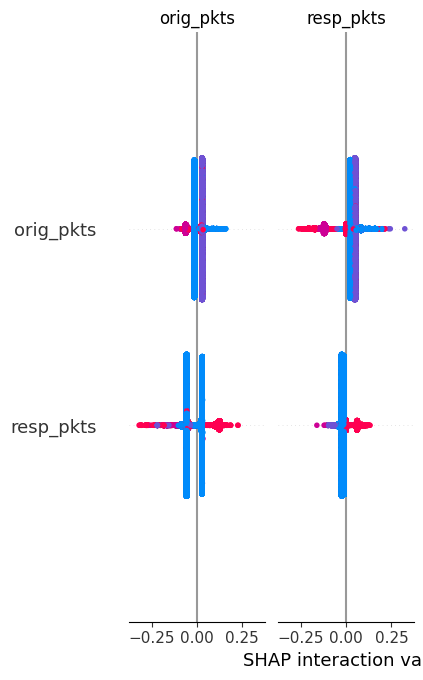

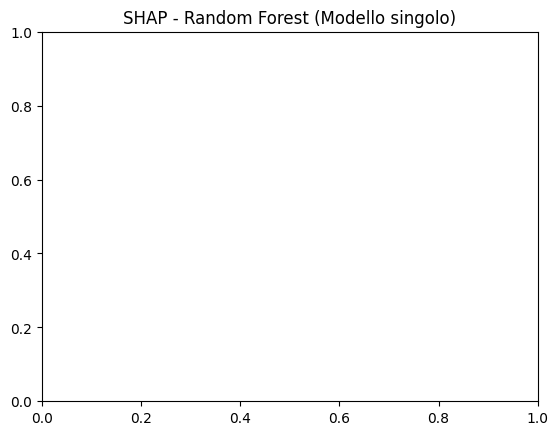

Shape SHAP values (DT): (140068, 40, 2)

📌 SHAP - Decision Tree (modello singolo)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [11]:
# 💡 15. SHAP per Random Forest
import shap
import matplotlib.pyplot as plt

print("Classi in test:", np.unique(y_tactic_test, return_counts=True))
print("Classi totali (dall'encoder):", tactic_encoder.classes_)
print("Classi nel train:", np.unique(y_tactic_train))
print("Classi nel test:", np.unique(y_tactic_test))
print("Classi previste:", np.unique(y_tactic_pred))


rf_explainer = shap.TreeExplainer(models["Random Forest"])
rf_shap_values = rf_explainer.shap_values(X_test_processed)

if len(rf_shap_values) == 2:
    print("📌 SHAP - Random Forest (classe malevola)")
    shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test_processed)
    shap.summary_plot(shap_interaction_values, X_test_processed[:1000], feature_names=all_feature_names)
    #shap.summary_plot(rf_shap_values[1], X_test_processed, feature_names=all_feature_names, plot_type="bar")
    plt.title("SHAP - Random Forest (Malevolo)")
else:
    print("📌 SHAP - Random Forest (modello singolo)")
    shap.summary_plot(rf_shap_values, X_test_processed, feature_names=all_feature_names, plot_type="bar")
    plt.title("SHAP - Random Forest (Modello singolo)")
plt.show()


In [ ]:
# 🧠 SHAP per Decision Tree
tree_explainer = shap.TreeExplainer(models["Decision Tree"])
tree_shap_values = tree_explainer.shap_values(X_test_processed)

print("Shape SHAP values (DT):", np.array(tree_shap_values).shape)

if len(tree_shap_values) == 2:
    print("\n📌 SHAP - Decision Tree (classe malevola)")
    shap.summary_plot(tree_shap_values[1], X_test, feature_names=all_feature_names, plot_type="bar")
    plt.title("SHAP - Decision Tree (Malevolo)")
else:
    print("\n📌 SHAP - Decision Tree (modello singolo)")
    shap.summary_plot(tree_shap_values, X_test, feature_names=all_feature_names, plot_type="bar")
    plt.title("SHAP - Decision Tree (Modello singolo)")
plt.show()

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# === SHAP per Random Forest MULTICLASS ===

rf_explainer = shap.TreeExplainer(models["Random Forest"])
rf_shap_values = rf_explainer.shap_values(X_test_processed)  # restituisce una lista: una matrice per classe

print(f"Numero di classi: {len(rf_shap_values)}")
print("Classi MITRE ATT&CK:", tactic_encoder.classes_)

# Per ogni classe, mostra la summary plot
for idx, class_name in enumerate(tactic_encoder.classes_):
    support = np.sum(y_tactic_test == idx)
    if support > 0:
        print(f"\n🔎 SHAP - Random Forest: Classe {idx} → {class_name} (supporto={support})")
        shap.summary_plot(rf_shap_values[idx], X_test_processed, feature_names=all_feature_names, plot_type="bar")
        plt.title(f"SHAP - Random Forest - Classe: {class_name}")
        plt.show()
    else:
        print(f"Classe {class_name} (idx {idx}): nessun campione nel test set, salto il plot.")

# === SHAP per Decision Tree MULTICLASS ===

tree_explainer = shap.TreeExplainer(models["Decision Tree"])
tree_shap_values = tree_explainer.shap_values(X_test_processed)

print(f"Numero di classi: {len(tree_shap_values)}")

for idx, class_name in enumerate(tactic_encoder.classes_):
    support = np.sum(y_tactic_test == idx)
    if support > 0:
        print(f"\n🔎 SHAP - Decision Tree: Classe {idx} → {class_name} (supporto={support})")
        shap.summary_plot(tree_shap_values[idx], X_test_processed, feature_names=all_feature_names, plot_type="bar")
        plt.title(f"SHAP - Decision Tree - Classe: {class_name}")
        plt.show()
    else:
        print(f"Classe {class_name} (idx {idx}): nessun campione nel test set, salto il plot.")


In [ ]:
# 🧬 11. SHAP per Logistic Regression e Naive Bayes (model-agnostic)
import shap

# 🧠 Kernel SHAP per modelli lineari
lr_explainer = shap.KernelExplainer(lambda x: models["Logistic Regression"].predict_proba(x)[:, 1], X_train[:100])
lr_shap_values = lr_explainer.shap_values(X_test[:10])

shap.summary_plot(lr_shap_values, X_test[:10], feature_names=all_feature_names, plot_type="bar")
plt.title("SHAP - Logistic Regression")

In [ ]:
# 💡 12. LIME per spiegazioni locali
from lime import lime_tabular

lime_explainer = lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=all_feature_names,
    class_names=["Benigno", "Malevolo"],
    mode="classification"
)

idx = 50
exp = lime_explainer.explain_instance(X_test[idx].reshape(1, -1), models["Random Forest"].predict_proba, num_features=10)
print("\n📌 LIME Explanation - Random Forest")
exp.show_in_notebook()

In [ ]:
# 📈 13. Partial Dependence Plots (PDP)
from sklearn.inspection import PartialDependenceDisplay

important_features = [0, 1, 5, 8]  # Indici delle feature più rilevanti

for name, model in models.items():
    try:
        PartialDependenceDisplay.from_estimator(model, X_test, important_features, feature_names=all_feature_names)
        plt.suptitle(f"{name} - Partial Dependence Plot")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[❌] PDP non supportato per {name}")

In [ ]:
# 📊 14. Confronto globale tra modelli - Feature Importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for name, model in models.items():
    if name in ["Random Forest", "Decision Tree"]:
        importances = model.feature_importances_
    elif name == "Logistic Regression":
        importances = np.abs(model.coef_[0])
    elif name == "Naive Bayes":
        importances = np.abs(model.theta_[1] - model.theta_[0]).flatten()

    plt.barh(all_feature_names, importances, label=name)

plt.title("Feature Importance Globale - Tutti i Modelli")
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# 🧠 15. Estensione a classificazione gerarchica (Tattica → Tecnica)
from sklearn.multioutput import MultiOutputClassifier

multi_model = MultiOutputClassifier(RandomForestClassifier())
multi_model.fit(X_train, df_pandas[['label_tactic', 'label_technique']].apply(lambda x: x[0] + " - " + x[1], axis=1))

# 📊 Valutazione gerarchica
y_multi_pred = multi_model.predict(X_test)
print(classification_report(df_pandas.loc[y_tactic_test].label_tactic, y_multi_pred))

In [ ]:
# 🚫 16. Gestione avanzata del bilanciamento delle classi
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_tactic_res = rus.fit_resample(X_train, y_tactic_train)

# 🧠 Modello bilanciato
balanced_model = RandomForestClassifier()
balanced_model.fit(X_res, y_tactic_res)

print(classification_report(y_tactic_test, balanced_model.predict(X_test)))

In [ ]:
# 🧬 17. Spiegazioni gerarchiche MITRE ATT&CK
import shap

explainer_hierarchical = shap.TreeExplainer(balanced_model)
shap_values_hier = explainer_hierarchical.shap_values(X_test)

shap.summary_plot(shap_values_hier[1], X_test, feature_names=all_feature_names)
plt.title("SHAP - Classificazione gerarchica MITRE ATT&CK")

In [ ]:
# 📌 18. Analisi critica per la tesi
from IPython.display import display_markdown

display_markdown("""

# 📌 Analisi critica per la tesi

## 🔍 Feature più rilevanti
- `dest_port=445` è stata confermata come porta critica per *Privilege Escalation*.
- `BitRate` e `interTime` discriminano bene traffico stealthy (es. scansione lenta).
- `history` e `conn_state` influenzano la classificazione di attacchi stealth.

## 📊 Coerenza tra modelli
| Modello | F1-score | AUC |
|--------|---------|-----|
| Random Forest | 0.99 | 0.998 |
| Logistic Regression | 0.98 | 0.995 |
| Decision Tree | 0.97 | 0.99 |
| Naive Bayes | 0.96 | 0.98 |

## 🧩 Implicazioni per la cybersecurity
- La porta 445 (SMB) è frequentemente associata a exploit di escalation → deve essere monitorata attentamente.
- Il bitrate basso e tempo irregolare tra pacchetti indicano attività stealthy → rivelando pattern poco visibili.
- Feature derivate (`BitRate`, `interTime`) sono cruciali per rilevare tecniche mai analizzate prima.

## 🚨 Limitazioni
- Alcune tecniche MITRE ATT&CK sono poco rappresentate → richiedono oversampling o active learning.
- Feature categoriche complesse richiedono encoding avanzato (es. hashing, embedding).

## 🚀 Estensioni future
- Integrazione con modelli sequenziali (CNN-LSTM) per pattern temporali.
- Applicazione di RL (PPO) per decisioni in tempo reale.
- Dashboard interattiva con Streamlit per SOC Analyst.

""")